In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from helpers import combine_position_data
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import root_mean_squared_error

In [2]:
data_directory = "Fantasy-Premier-League/data"
seasons = ["2022-23", "2023-24", "2024-25"]
positions = ["DEF", "MID", "FWD"]
output_file_name = "xg_training_data.csv"

combine_position_data(data_directory, seasons, positions, output_file_name)

Loaded data from DEF_players.csv for season 2022-23.
Loaded data from MID_players.csv for season 2022-23.
Loaded data from FWD_players.csv for season 2022-23.
Loaded data from DEF_players.csv for season 2023-24.
Loaded data from MID_players.csv for season 2023-24.
Loaded data from FWD_players.csv for season 2023-24.
Loaded data from DEF_players.csv for season 2024-25.
Loaded data from MID_players.csv for season 2024-25.
Loaded data from FWD_players.csv for season 2024-25.
Combined data saved to Fantasy-Premier-League/data/training_data/xg_training_data.csv.


In [4]:
data_directory = "Fantasy-Premier-League/data/training_data"
training_file = os.path.join(data_directory, "xg_training_data.csv")
data = pd.read_csv(training_file)

features = [
    "gameweek", "season", "value", "was_home", "POS", 
    "opponent_defense", "own_attack", "crowds"
]
target = "expected_goals"

X = data[features]
y = data[target]

X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse}")

models_folder = "models"
os.makedirs(models_folder, exist_ok=True)
model_path = os.path.join(models_folder, "xgboost_xg_prediction_model.json")
model.save_model(model_path)
print(f"Model saved at: {model_path}")

RMSE: 0.13774301598294159
Model saved at: models/xgboost_xg_prediction_model.json


<Figure size 1000x800 with 0 Axes>

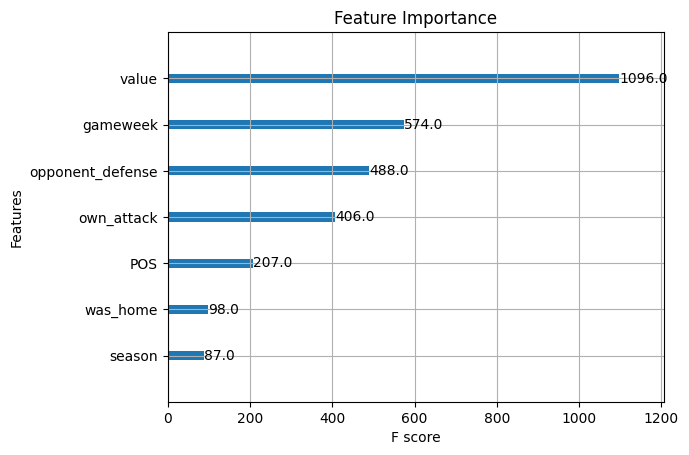

In [5]:
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=10, importance_type="weight")
plt.title("Feature Importance")
plt.show()